In [1]:
import json
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
import sklearn.cluster as cluster
import time
import scipy
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's':80, 'linewidths':0}

In [21]:
# user input
user_input = 'Restaurants'
u_id = 'McLqvYLBQoCFQikU9dC4cQ'

In [9]:
# initialize business data
bcmap = {}
with open('./business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        
        key = l['business_id']
        #Business Category Dictionary
        category = l['categories']
        bcmap[key] = category

# generate top categories
category = {}
for i in bcmap:
    if user_input in bcmap[i]:
        for j in bcmap[i]:
            if j not in category:
                category[j] = 1
            else:
                category[j] += 1
top_cate = sorted(category.items(), key=lambda x:(-x[1]))[1:21]
tc = []
for i in top_cate:
    tc.append(i[0])
    
# initialize business data   
location = {}
bcrmap = {}
business_name = {}
with open('./business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        key = l['business_id']
        category = l['categories']
        
        # Business City Dictionary
        city = l['city']
        location[key] = city
        
        # Business -> Category -> Star Dictionary
        stars = l['stars']
        valid = False
        number_of_tc = 0
        if key not in bcrmap:
            bcrmap[key] = {}
        for i in category:
            if i in tc:
                number_of_tc += 1
                valid = True
                bcrmap[key].setdefault(i,[]).append(stars)
        if not valid or number_of_tc <3:
            del bcrmap[key]
            
            
        # Business name -> Address Dictionary
        name = l['name'] +','  + l['address'] +','  + l['city'] +',' + l['state']
        business_name[key] = name
        

In [10]:
tc

['Food',
 'Nightlife',
 'Bars',
 'Sandwiches',
 'Fast Food',
 'American (Traditional)',
 'Pizza',
 'Italian',
 'Burgers',
 'Breakfast & Brunch',
 'Mexican',
 'American (New)',
 'Chinese',
 'Cafes',
 'Coffee & Tea',
 'Japanese',
 'Chicken Wings',
 'Seafood',
 'Event Planning & Services',
 'Salad']

In [14]:
# initialize user review data
# User -> Categories -> Stars
ucrmap = {}
with open('./review.json', 'r') as rv:
    for line in rv:
        n1 = json.loads(line)
        okey = n1['user_id']
        ikeys = bcmap[n1['business_id']]
        value = n1['stars']
        if n1['user_id'] not in ucrmap:
            ucrmap[okey] = {}
        for ikey in ikeys:
            if ikey in tc:
                ucrmap[okey].setdefault(ikey, []).append(value)

In [20]:
n = 0
for k, v in ucrmap.items():
    n += 1
    if n < 5:
        print(k, '           ', v)

JT3Cnb1AL2ME2hR1W82I8g             {'Seafood': 0, 'Fast Food': 0, 'Chicken Wings': 0, 'American (Traditional)': 0, 'Sandwiches': 0, 'Nightlife': 0, 'Cafes': 0, 'Italian': 0, 'Event Planning & Services': 0, 'Mexican': 0, 'Food': 0, 'Burgers': 0, 'Bars': 0, 'Japanese': 0, 'American (New)': 0, 'Pizza': 0, 'Breakfast & Brunch': 0, 'Coffee & Tea': 0, 'Salad': 0, 'Chinese': 0}
O_IeIHn3iGacjlSj8Z9cFg             {'Seafood': 0, 'Chicken Wings': 0, 'American (Traditional)': 3, 'Fast Food': 0, 'Nightlife': 5, 'Bars': 5, 'Italian': 5, 'Event Planning & Services': 0, 'Mexican': 0, 'Food': 4, 'Cafes': 0, 'Burgers': 0, 'Sandwiches': 0, 'Japanese': 0, 'American (New)': 3, 'Pizza': 0, 'Breakfast & Brunch': 2, 'Coffee & Tea': 0, 'Salad': 0, 'Chinese': 0}
DDzs0zVelAStqGwm1j6U9A             {'Fast Food': 0, 'Chicken Wings': 0, 'Event Planning & Services': 4, 'Sandwiches': 0, 'Nightlife': 0, 'American (New)': 0, 'Cafes': 0, 'Italian': 4, 'Burgers': 0, 'Mexican': 3.3333333333333335, 'Seafood': 4, 'Food': 1

In [12]:

for business in bcrmap:
    for k, v in bcrmap[business].items():
        bcrmap[business][k] = statistics.mean(v)
        
for business in bcrmap:
    for i in tc:
        if i not in bcrmap[business]:
            bcrmap[business][i] = 0
            
nbcrmap = {}
for k, v in bcrmap.items():
    nbcrmap[k] = []
    for i, j in v.items():
        nbcrmap[k].append(j)

In [15]:
# Compose user category vector
for user in ucrmap:
    for cate, value in ucrmap[user].items():
        ucrmap[user][cate] = statistics.mean(value)
for user in ucrmap:
    for i in tc:
        if i not in ucrmap[user]:
            ucrmap[user][i] = 0
            
nucrmap = {}
for k, v in ucrmap.items():
    nucrmap[k] = []
    for i, j in v.items():
        nucrmap[k].append(j)

In [16]:
# create a proximity matrix between users
listV = list(nucrmap.values())
listK = list(nucrmap.keys())
pm = []

for i in range(1000):
    pm.append([])
    for j in range(0,1000):
        if i == j:
            pm[i].append(0)
        else:
            v1 = listV[i]
            v2 = listV[j]
            dst1 = distance.euclidean(v1, v2)
            pm[i].append(dst1)

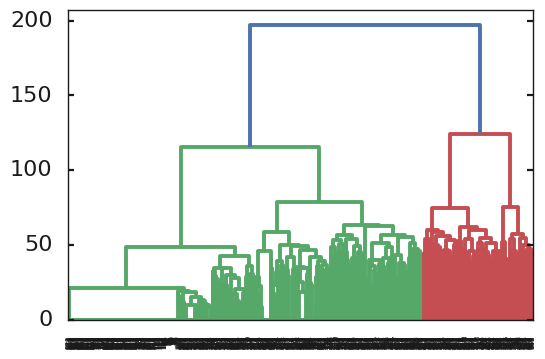

In [17]:
# Agglomerative clustering using scipy
Z = scipy.cluster.hierarchy.linkage(pm, method='average')
plt.clf()
fig = plt.figure()
dd = scipy.cluster.hierarchy.dendrogram(Z)
plt.savefig('{}.pdf'.format('average'))
plt.show()

In [53]:
#agglomerative clustering using sklearn 
data = []
for k,v in nucrmap.items():
    data.append(v)
np.save('123', np.array(data[:1000]))
data1 = np.load('123.npy')

In [63]:
# get number of clusters from above plot and generate clusters dictionary
model = cluster.AgglomerativeClustering(linkage='average', n_clusters=10)
result = model.fit_predict(data1)
clusters = {}
for i in range(len(result)):
    k = result[i]
    v = data1[i]
    clusters.setdefault(k, []).append(v)

In [64]:
# user index corresponding to user vector dictionary
index = listK.index(u_id)

In [65]:
# Average Vector for each cluster generated above

average_vector = {}
for i in list(clusters.keys()):
    average_vector[i] = np.mean(clusters[i], axis=0)
    

In [66]:
# Get the users cluster vector 
user_vector = average_vector[result[index]]

In [67]:
# Perfor inner dot product between user_vector and each business vector

result_bcrmap = {}
for i in nbcrmap:
    result_bcrmap[i] = np.inner(user_vector, nbcrmap[i])

In [68]:
# Sort the business based on the minimum value of above operation. Keep top 20 businesses
top_business = sorted(result_bcrmap.items(), key=lambda x:(x[1]))[1:21]

In [69]:
# print out the recommended businesses

for k,v in top_business:
    print(business_name[k])

Pizza Hut,7941 Euclid Ave,Cleveland,OH
Pizza Hut,1909 Milton Rd,Charlotte,NC
Pizza Hut,3530 Mt Holly Hunterville Rd,Charlotte,NC
Pizza Hut,10616 Lorain Ave,Cleveland,OH
Pizza Hut,6557 Broadway Ave,Cleveland,OH
Pizza Hut,1008 N Court St,Medina,OH
Pizza Hut,3734 W T Harris Blvd,Charlotte,NC
Pizza Pizza,1197 Ellesmere Road,Scarborough,ON
Pizza Hut,20515 Southgate Park Rd, Ste 100,Cleveland,OH
Pizza Hut,1165 Mentor Ave,Painesville,OH
Pizza Hut,130 Davis Drive,Newmarket,ON
Pizza Hut,2324 Ardmore Blvd,Forest Hills,PA
Pizza Hut,1112 Washington Pike,Bridgeville,PA
Pizza Hut,34165 Aurora Rd,Solon,OH
Pizza Hut,10050 W Bell Rd, Ste 22,Sun City,AZ
Pizza Hut,9045 Airport Road,Brampton,ON
KFC,16599 Yonge Street,Newmarket,ON
Salsarita's Fresh Mexican Grill,8111 Concord Mills Blvd, Ste 101,Concord,NC
KFC,1516 Greenway Cross,Madison,WI
Popeyes,3420 William Penn Hwy,Pittsburgh,PA


------
What to do next
==================
Apply one million on the dataset
